In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from sklearn.utils import compute_class_weight

from convolution_patterns.config import Config
from convolution_patterns.logger_manager import LoggerManager
from convolution_patterns.services.image_dataset_service import ImageDatasetService
from convolution_patterns.services.transform_service import TransformService

[Config] Resolved (PROJECT_ROOT): configs/transforms_used.yaml → /Users/kenneth/Public/projects/python/ai/convolution-patterns/configs/transforms_used.yaml
[Config] Resolved (fallback to BASE_DIR): configs/backbones/EfficientNetB0.yaml → /Users/kenneth/Public/projects/python/ai/convolution-patterns/artifacts/configs/backbones/EfficientNetB0.yaml


In [2]:
logging = LoggerManager.get_logger("class_distribution_analysis")

In [3]:
config_path = "../../configs/train_config.yaml"

In [4]:
cfg = Config()
cfg.load_from_yaml(config_path)
print("PROJECT ROOT:", cfg.PROJECT_ROOT)
print("BASE DIR:", cfg.BASE_DIR)
print("RAW DATA:", cfg.RAW_DATA_DIR)
print("PROCESSED DATA:", cfg.PROCESSED_DATA_DIR)
print("REPORTS DATA:", cfg.REPORTS_DIR)

[Config] Loaded YAML config: ../../configs/train_config.yaml
[Config] Overriding 'debug': False → True
[Config] Overriding 'staging_dir': None → ./artifacts/staging
[Config] Overriding 'preserve_raw': True → True
[Config] Overriding 'label_mode': pattern_only → pattern_only
[Config] Overriding 'split_ratios': [70, 15, 15] → [70, 15, 15]
[Config] Overriding 'random_seed': 42 → 1337
[Config] Overriding 'image_size': (224, 224) → [224, 224]
[Config] Overriding 'batch_size': 32 → 32
[Config] Overriding 'epochs': 10 → 400
[Config] Overriding 'cache': False → True
[Config] Overriding 'include_classes': None → None
[Config] Overriding 'exclude_classes': [] → ['No_Pattern']
PROJECT ROOT: /Users/kenneth/Public/projects/python/ai/convolution-patterns
BASE DIR: /Users/kenneth/Public/projects/python/ai/convolution-patterns/artifacts
RAW DATA: /Users/kenneth/Public/projects/python/ai/convolution-patterns/artifacts/data/raw
PROCESSED DATA: /Users/kenneth/Public/projects/python/ai/convolution-pattern

In [5]:
print_stats = True
# Load transform config
path = cfg.transform_config_path
if path is None:
    raise ValueError("Transform config path must not be None.")

transform_service = TransformService.from_yaml(path)
train_pipeline = transform_service.get_pipeline(mode="train")
val_pipeline = transform_service.get_pipeline(mode="val")

#cfg.exclude_classes = ['No_Pattern']
# Load datasets
dataset_service = ImageDatasetService()
train_ds, train_class_names = dataset_service.get_dataset(
    "train", print_stats=print_stats, prefetch=False
)
val_ds, val_class_names = dataset_service.get_dataset(
    "val", print_stats=print_stats, prefetch=False
)

# Apply transformations
train_ds = train_ds.map(
    lambda x, y: (train_pipeline(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.map(
    lambda x, y: (val_pipeline(x), y), num_parallel_calls=tf.data.AUTOTUNE
)

[ 2025-07-22 07:17:12 ] INFO [../../src/convolution_patterns/services/image_dataset_service.py:81] - ✅ Using class names: ['Downtrend', 'Trend_Change_Bear', 'Trend_Change_Bull', 'Uptrend']
Found 1074 files belonging to 4 classes.
[ 2025-07-22 07:17:12 ] INFO [../../src/convolution_patterns/services/image_dataset_service.py:36] - 

📊 Dataset: train
  ➤ Image shape: (32, 224, 224, 3), dtype: <dtype: 'float32'>
  ➤ Label shape: (32, 4), dtype: <dtype: 'float32'>
  ➤ Total images: 1074
  ➤ Number of batches: 34
  ➤ Number of classes (inferred): 4
  ➤ Class Names: ['Downtrend', 'Trend_Change_Bear', 'Trend_Change_Bull', 'Uptrend']
[ 2025-07-22 07:17:12 ] INFO [../../src/convolution_patterns/services/image_dataset_service.py:81] - ✅ Using class names: ['Downtrend', 'Trend_Change_Bear', 'Trend_Change_Bull', 'Uptrend']
Found 110 files belonging to 4 classes.
[ 2025-07-22 07:17:12 ] INFO [../../src/convolution_patterns/services/image_dataset_service.py:36] - 

📊 Dataset: val
  ➤ Image shape: (32

2025-07-22 07:17:12.254397: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-07-22 07:17:12.254415: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-07-22 07:17:12.254419: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-07-22 07:17:12.254433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-22 07:17:12.254443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-07-22 07:17:12.412052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-22 07:17:12.436413: 

In [6]:
# Extract images and labels from tf.data.Dataset
def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []
    for batch_images, batch_labels in dataset:
        images_list.append(batch_images.numpy())
        labels_list.append(batch_labels.numpy())
    images = np.concatenate(images_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return images, labels


# train_images, train_labels_onehot = dataset_to_numpy(train_ds)
# train_labels = np.argmax(train_labels_onehot, axis=1)

# # Calculate mean pixel intensity per image
# mean_intensity = train_images.mean(axis=(1, 2, 3))

# # Create DataFrame for plotting
# df = pd.DataFrame(
#     {
#         "mean_intensity": mean_intensity,
#         "class": [train_class_names[i] for i in train_labels],
#     }
# )

# plt.figure(figsize=(14, 7))
# sns.boxplot(x="class", y="mean_intensity", data=df)
# plt.xticks(rotation=45)
# plt.title("Mean Pixel Intensity Distribution per Class")
# plt.show()

In [7]:
def _extract_integer_labels(dataset):
    labels = []
    for _, one_hot_labels in dataset.unbatch():
        label = tf.argmax(one_hot_labels).numpy()
        labels.append(label)
    return np.array(labels)


2025-07-22 07:17:12.498849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-22 07:17:12.652865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


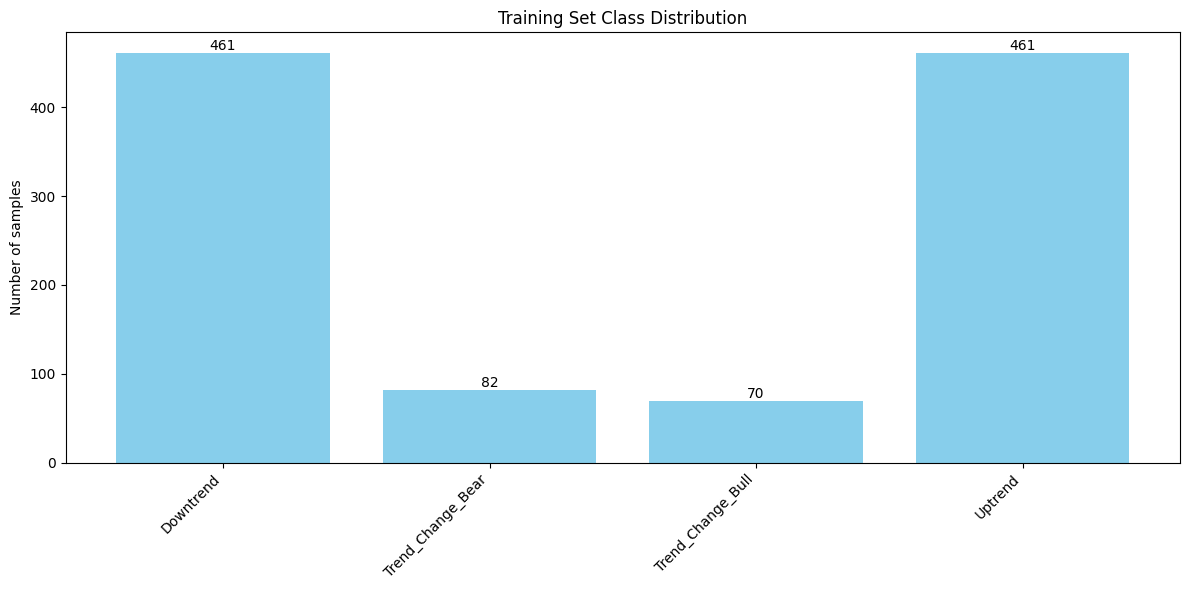

In [8]:
def get_class_distribution(labels_onehot, class_names):
    # Convert one-hot labels to class indices
    labels = np.argmax(labels_onehot, axis=1)
    counts = Counter(labels)
    distribution = {class_names[i]: counts[i] for i in range(len(class_names))}
    return distribution


def plot_class_distribution(distribution, title="Class Distribution"):
    classes = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(12, 6))
    bars = plt.bar(classes, counts, color="skyblue")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of samples")
    plt.title(title)

    # Add counts on top of bars
    for bar, count in zip(bars, counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(count),
            ha="center",
            va="bottom",
        )
    plt.tight_layout()
    plt.show()


# Example usage with your train dataset
train_images, train_labels_onehot = dataset_to_numpy(
    train_ds
)  # Use the function from earlier
train_distribution = get_class_distribution(train_labels_onehot, train_class_names)
plot_class_distribution(train_distribution, title="Training Set Class Distribution")

# If you want to track after augmentation, do the same for augmented dataset labels
# augmented_images, augmented_labels_onehot = dataset_to_numpy(augmented_ds)
# augmented_distribution = get_class_distribution(augmented_labels_onehot, train_class_names)
# plot_class_distribution(augmented_distribution, title="Augmented Set Class Distribution")

In [9]:
for images, labels in train_ds.take(1):
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    print("Label sample:", labels[0])

Image shape: (32, 224, 224, 3)
Label shape: (32, 4)
Label sample: tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


2025-07-22 07:17:12.991183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
train_labels = _extract_integer_labels(train_ds)
unique_labels = np.unique(train_labels)
# Step 2: Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=unique_labels, y=train_labels
)
# Build both dicts: index to weight, and label to weight
index_to_weight = {i: w for i, w in enumerate(class_weights)}
label_to_weight = {train_class_names[i]: w for i, w in enumerate(class_weights)}

print("Index to weight:")
for k, v in index_to_weight.items():
    print(f"  {k}: {v:.4f}")

print("\nLabel to weight:")
for label, weight in label_to_weight.items():
    print(f"  {label}: {weight:.4f}")

2025-07-22 07:17:13.189143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Index to weight:
  0: 0.5824
  1: 3.2744
  2: 3.8357
  3: 0.5824

Label to weight:
  Downtrend: 0.5824
  Trend_Change_Bear: 3.2744
  Trend_Change_Bull: 3.8357
  Uptrend: 0.5824
